#  Medical Deep Learning

## Weakly-Supervised Visualization


In [ ]:
import sys

!pip install -q wget

import torch
import torchvision
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import matplotlib.cm as mpl_color_map
import os
import wget
import zipfile

%matplotlib inline
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
dataset_url = 'https://cloud.imi.uni-luebeck.de/s/KwD3fs4q6ctqmA8/download'

def get_data(data_url):
    filename = './MDL3_data.zip'
    if not os.path.exists(filename):
        filename = wget.download(data_url)
    zipfile.ZipFile(filename,'r').extractall()
    
get_data(dataset_url)

In [ ]:
# Function for Heatmap Overlays (expects gray-scale image as numpy and heatmap as torch array)
def overlayParula(grayim_numpy,heatmap_torch,smooth=False):
    
    heat_max = torch.kthvalue(heatmap_torch.view(-1), int(.95*heatmap_torch.numel()))[0]
    heat_min = torch.min(heatmap_torch)
    heatmap_torch = torch.clamp((heatmap_torch-heat_min)/(heat_max-heat_min),0,1)
    if(smooth==True):
        heatmap_torch = F.avg_pool2d(F.avg_pool2d(F.max_pool2d(heatmap_torch.unsqueeze(0).unsqueeze(0),3,stride=1,padding=1),3,stride=1,padding=1),3,stride=1,padding=1).squeeze()


    x = np.linspace(0.0, 1.0, 256)
    rgb_jet = mpl_color_map.get_cmap(plt.get_cmap('jet'))(x)[:,:3]
    rgb_gray = mpl_color_map.get_cmap(plt.get_cmap('gray'))(x)[:,:3]
    #rgb_viridis
    rgb_heat = rgb_jet[(heatmap_torch*255).numpy().astype('uint8'),:]
    rgb_base = rgb_gray[(grayim_numpy*255).astype('uint8'),:]

    rgb0 = (rgb_heat*127.5+rgb_base*127.5).astype('uint8')
    weight = torch.tanh((heatmap_torch-0.5)*3)*0.5+0.5
    alpha = torch.clamp(1.0 - 0.5*weight,0,1.0)
    overlay = rgb_base*alpha.unsqueeze(2).numpy() + rgb_heat*(1.0-alpha).unsqueeze(2).numpy()
        
    return overlay

# Function to compute the number of trainable parameters in a given model
def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

# Function to compute the Dice value given the ground truth segmentation of a slice
# and the guided_backpropagation_map or the CAM map as <pred>
def oracle_dice(pred,gt_th):
    val,idx = torch.sort(pred.data.flatten(),descending=True)
    gt_sort = gt_th.flatten()[idx]
    intersect = torch.cumsum(gt_sort,0).float()
    cardinal = (gt_th.flatten()>0.5).float().sum()+torch.arange(pred.numel()).float()
    all_dices = 2*intersect/torch.clamp(cardinal,min=.001)
    return all_dices.max(),val[all_dices.argmax()]

## Task 0: Visualize the given pancreas train & test data

In [ ]:
#read and pre-process image   
train_imgs = torch.load('train_imgs.pth')
train_imgs = torch.cat(train_imgs,0).view(-1,3,224,224)
train_imgs = ((train_imgs.float()) / 255.0).cuda()

train_labels = torch.load('train_labels.pth')
train_labels = torch.cat(train_labels,0).view(-1).cuda()

test_imgs = torch.load('test_imgs.pth')
test_imgs = torch.cat(test_imgs,0).view(-1,3,224,224)
test_imgs = ((test_imgs.float()) / 255.0).cuda()

test_labels = torch.load('test_labels.pth')
test_labels = torch.cat(test_labels,0).view(-1).cuda()

test_segmentations = torch.load('test_segmentations.pth')
test_segmentations = torch.cat(test_segmentations,0).view(-1,224,224).cuda()

[]

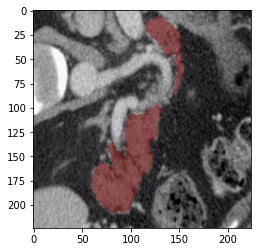

In [ ]:
##### Visualize some input training & test slices
##### For training data only the labels are given, for the test datasets also segmentation masks are provided

overlay = overlayParula(test_imgs[100,0,:,:].cpu().numpy(),test_segmentations[100].cpu())
plt.imshow(overlay)
plt.plot()



## Finetuning a pretrained ResNet on the given data 

In [ ]:
# Note: The train & test data are given with values in the range [0,1]. Because pretrained CNNs on ImageNet 
# expect a specific input value distribution and 3-channel RGB data, we
# 1) have to apply ImageNet-based mean and standard deviation to our data 
# 2) we feed 3 neighboring slices as input channels to our networks (already done...)

# Below we provide the mean and std values from the ImageNet data

means = torch.Tensor([0.485, 0.456, 0.406]).view(1,3,1,1).cuda()
stds = torch.Tensor([0.229, 0.224, 0.225]).view(1,3,1,1).cuda()

print("before:", torch.std_mean(train_imgs), torch.std_mean(test_imgs))
normlz = torchvision.transforms.Normalize(mean=means, std=stds)
train_imgs = normlz(train_imgs)
test_imgs = normlz(test_imgs)
print("after:", torch.std_mean(train_imgs), torch.std_mean(test_imgs))

before: (tensor(0.2644, device='cuda:0'), tensor(0.4469, device='cuda:0')) (tensor(0.2685, device='cuda:0'), tensor(0.4879, device='cuda:0'))
after: (tensor(1.1780, device='cuda:0'), tensor(-0.0085, device='cuda:0')) (tensor(1.1958, device='cuda:0'), tensor(0.1730, device='cuda:0'))


Load a pretrained ResNet18 model from the torchvision model zoo & and modify it accordingly to our needs:
- with foresight to the gradCAM method, we need the last feature layer to have a sufficiently large spatial dimensions; therefore we need to replace the ResNet.Layer4 Sequential block with an identity operation; HINT: you can use e.g. an AvgPool2D-Layer; think about how to choose the kernelsize and stride
- Since in addition to a larger spatial output of the last feature layer, we also want a more lightweight model, we modify the building blocks of Layer3.
    1. Replace conv1 in layer3[0] with a Conv2D(), (in=128,out=256,k_sz=3, stride=1, pad=1, bias=False)
    2. Replace conv2 in layer3[0] with a Conv2D(), (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)
    3. Replace downsample[0] in layer3[0] with a Conv2D(), (in=128,out=256,k_sz=1, stride=1, pad=0, bias=False)
    4. Replace conv1 in layer3[1] with a Conv2D(), (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)
    5. Replace conv2 in layer3[1] with a Conv2D(), (in=256,out=256,k_sz=3, stride=1, dil=2, pad=2, bias=False)
- Finally: replace the fully connected layer: Inspect the number of input & output channels for the ImageNet classification task and modify this layer accordingly to our "(presence/absence) of the pancreas" classification problem.

Now, we have a ResNet14.

In [ ]:
my_resnet = torchvision.models.resnet18(pretrained=True)
#print(my_resnet)

# test switch: if you want to train a larger ResNet18 first to verify your train loop, only modify the 
# fully connected layer below
lightweight = True

my_resnet.layer4 = nn.Identity()

if(lightweight):
    # replace the modules according to the description given above
    my_resnet.layer3[0].conv1 = nn.Conv2d(128,256,3,padding=1,bias=False)
    # replace the remaining layers
    my_resnet.layer3[0].conv2 = nn.Conv2d(256,256,3,padding=2, dilation=2,bias=False)
    my_resnet.layer3[0].downsample[0] = nn.Conv2d(128,256,1,padding=0,bias=False)
    my_resnet.layer3[1].conv1 = nn.Conv2d(256,256,3,padding=2, dilation=2, bias=False)
    my_resnet.layer3[1].conv2 = nn.Conv2d(256,256,3,padding=2, dilation=2, bias=False)

if(lightweight):
    # replace the fully connected layer
    my_resnet.fc = nn.Linear(in_features=256, out_features=2, bias=False)
else:
    my_resnet.fc = nn.Linear(in_features=256, out_features=1000, bias=False)


print(my_resnet)

my_resnet.cuda()

print(countParameters(my_resnet))

Finetuning the ResNet14 to the training data:

In [ ]:
torch.manual_seed(30)

nr_epx = 10
b_sz_train = 32
init_lr = 0.0005
decay = 0.95

# initialize the optimizer and scheduler
optimizer = optim.Adam(my_resnet.parameters(), lr=init_lr)#
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay)
metric = nn.CrossEntropyLoss()

run_loss = np.zeros(nr_epx)/0
run_acc = np.zeros(nr_epx)/0


for epoch in range(nr_epx):

    run_loss[epoch] = 0
    run_acc[epoch] = 0
    
    # generate a random permutation tensor to draw random batches from the given training data
    train_perm = torch.randperm(train_imgs.size(0))
    
    
    # loop over all batches
    for i in range(0,train_imgs.size(0), b_sz_train):


        optimizer.zero_grad()
        
        # draw the current random image batch and the associated class labels 
        # based on the random permutation tensor
        # HINT: don't forget to adapt the input value range
        img_batch = train_imgs[train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# 
        
        label_batch = train_labels[train_perm[max(0, i-b_sz_train):max(i, b_sz_train)]].cuda()# 
        
        output = my_resnet(img_batch)

        loss = metric(output,label_batch)
        accuracy = torch.mean((output.argmax(1)==label_batch).float())
        loss.backward()
        optimizer.step()
        
        # keep track of the accuracy
        run_acc[epoch] += accuracy#
        
    run_acc[epoch] /= (train_imgs.size(0)/b_sz_train)# 
    run_loss[epoch] += loss.item()
    
    print(epoch+1,'/',nr_epx,'loss',run_loss[epoch],'accuracy',run_acc[epoch])
    scheduler.step()

# SAVE THE TRAINED MODEL
torch.save(my_resnet.cpu(),'mdl_resnet14.pth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


1 / 10 loss 0.033758413046598434 accuracy 0.93046875
2 / 10 loss 0.02280847355723381 accuracy 0.9921875
3 / 10 loss 0.002166670048609376 accuracy 0.9984375
4 / 10 loss 0.008141330443322659 accuracy 1.0
5 / 10 loss 0.0011921159457415342 accuracy 1.0
6 / 10 loss 0.000849032134283334 accuracy 1.0
7 / 10 loss 0.0007307367632165551 accuracy 1.0
8 / 10 loss 0.0005883874837309122 accuracy 1.0
9 / 10 loss 0.00042140434379689395 accuracy 1.0
10 / 10 loss 0.0005323931691236794 accuracy 1.0


In [ ]:
# check the model's accuracy on the test dataset

my_resnet = torch.load('mdl_resnet14.pth')
my_resnet.eval()
my_resnet.cuda()

test_acc = 0.0

# LOOP over the testdata set
for i in range(0,test_imgs.size(0), b_sz_train):
  with torch.no_grad():


    # draw the current random image batch and the associated class labels 
    # based on the random permutation tensor
    # HINT: don't forget to adapt the input value range
    img_batch = test_imgs[max(0, i-b_sz_train):max(i, b_sz_train)].cuda()# 

    label_batch = test_labels[max(0, i-b_sz_train):max(i, b_sz_train)].cuda()# 

    output = my_resnet(img_batch)

    #loss = metric(output,label_batch)
    accuracy = torch.mean((output.argmax(1)==label_batch).float())

    # : keep track of the accuracy
    test_acc += accuracy#
    
print('Test accuracy:', test_acc/(test_imgs.size(0)/b_sz_train))

Test accuracy: tensor(0.7719, device='cuda:0')


# CAM method for week visualisation

Now that we have our trained ResNet14 at hand, we want to visualize the class activation map (CAM).
Therefore, we need to implement the following steps:
1. Load the saved ResNet
2. Beforehand, the fully connected layer operated on 256-channel images without spatial dimensions only; now, we want to classify each of the 28x28 spatial features with their 256-channels using the trained weights from the fully connected layer; in order to do so, you can use a Conv2d with kernelsize=1. Think about how to choose the input & output channel dimensionality and how to transfer the fc.weight & fc.bias data from the pretrained ResNet to the Conv2D "classifier" module.
3. Since we are interested in the last feature layer output, we want to omit the avg_pool & fc layer.
4. Generate the class activation maps, be sequentially feeding a test image through the modified ResNet (with adapted avg-pool & fc layers) and the classifier module. Upsample the foreground channel to spatial dimensions corresponding to the input image & overlay the CAM to visualize the result.
5. Finally, use the oracle_dice function to compute the DICE score

TestIdx: 256
TestLabel: tensor(1, device='cuda:0')
torch.Size([1, 256, 28, 28]) torch.Size([1, 2, 28, 28])
TestIdx: 258
TestLabel: tensor(1, device='cuda:0')
torch.Size([1, 256, 28, 28]) torch.Size([1, 2, 28, 28])
TestIdx: 260
TestLabel: tensor(1, device='cuda:0')
torch.Size([1, 256, 28, 28]) torch.Size([1, 2, 28, 28])
tensor(0.3271)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


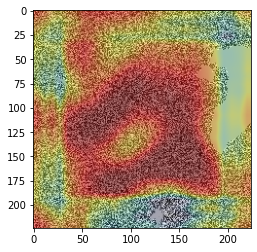

In [ ]:
dice_all = []
for test_idx in range(256,262,2):
    if(test_labels[test_idx]==0):
        continue
    print('TestIdx:',test_idx)
    print('TestLabel:', test_labels[test_idx])
    test_back_seg = test_segmentations[test_idx,:,:].cuda()
    test_back_orig = test_imgs[test_idx:test_idx+1,:,:,:].cuda()
    test_back = (test_back_orig-means.view(1,3,1,1))/stds.view(1,3,1,1)
    test_back = test_back.cuda()

    features = torch.load('mdl_resnet14.pth')
    features.cuda()

    # load the net

    # initialize the convd2 layer
    classifier = nn.Conv2d(256,2, 1, bias=True).cuda()
    #print(features.fc.state_dict())
    #classifier.load_state_dict(features.fc.state_dict())

    classifier.weight = torch.nn.Parameter(features.fc.weight.view(classifier.weight.shape))
    classifier.bias = features.fc.bias
    classifier.eval()

    # replace the avgpool & fc layers
    spat_feat = torch.nn.Sequential(*list(features.children())[:-2]).cuda()
    spat_feat.eval()

    # feed the test image through the modified net & classifier
    feats = spat_feat(test_back)
    outp = classifier(feats)
    print(feats.shape, outp.shape)

    # upsample the activation map & visualize the overlay
    upsmpl = nn.Upsample(scale_factor=8, mode='bilinear')
    #print(test_back.shape, upsmpl(feats).shape)
    overlay = overlayParula(test_back[0, 0, :,:].cpu().numpy(),upsmpl(outp)[0, 1, :,:].cpu().detach())
    plt.imshow(overlay)
    #plt.imshow(test_back[0, 0, :,:].cpu().numpy())
    plt.plot()

    # compute the dice score & append it to dice_all
    dice_all.append(oracle_dice(upsmpl(feats)[0, 0, :,:].cpu(),test_back_seg.cpu()))
    
print(torch.FloatTensor(dice_all).mean())